In [1]:
import json
import numpy as np
import pandas as pd
import trackpy as tp
import matplotlib.pyplot as plt

from src.FormatConversions import *
from src.Segmentation3D import get_voxel_size_35mm
from src.HolomonitorFunctions import get_pixel_size

In [2]:
vox_to_um = get_voxel_size_35mm()
pix_to_um = get_pixel_size()

In [64]:
# Holomonitor
dir  = "../data/Holomonitor/MDCK_01.03.2024/"
file = "B2-5"

# dir  = "../data/Tomocube/MDCK_10.02.2025/A2P1"
# file = "250210.113448.MDCK dynamics.001.MDCK B.A2"

In [65]:
# load config and data
unfiltered_df = pd.read_csv(f"{dir}{file}/area_volume_unfiltered.csv")
areas         = np.load(f"{dir}{file}/cell_areas.npy")
config        = json.load(open(f"{dir}{file}/config.txt"))


fmin = config["fmin"]
fmax = config["fmax"]

In [66]:
# Holomonitor
im = import_holomonitor_stack(dir, file, f_min=fmax, f_max=fmax)
search_range = 10

# Tomocube
# im, _ = import_tomocube_stack(folder, file, vox_to_um[0], f_min=1, f_max=40)
# search_range = 50

In [67]:
# Set filter parameters
A_min = 150  / pix_to_um[0] ** 2
A_max = 3000 / pix_to_um[0] ** 2
V_min = 1000 / pix_to_um[0] ** 2
V_max = 20_000 / pix_to_um[0] ** 2
h_min = 2
h_max = 18


# create masks
h_mask = (unfiltered_df.h_avrg > h_min) * (unfiltered_df.h_max < h_max) 
A_mask = (unfiltered_df.A > A_min) * (unfiltered_df.A < A_max)
V_mask = (unfiltered_df.V > V_min) * (unfiltered_df.V < V_max)

mask = h_mask * A_mask * V_mask
filtered_df = unfiltered_df[mask]

print(f"Before filtering: {len(unfiltered_df)} cells")
print(f"After filtering:  {len(filtered_df)} cells")

Before filtering: 27250 cells
After filtering:  3196 cells


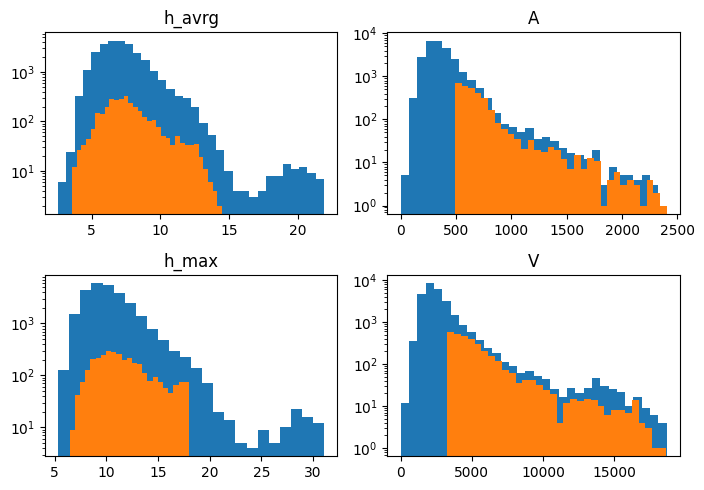

In [69]:
# filter area and volume
fig, ax = plt.subplots(2,2, figsize=(7,5))

ax[0,0].hist(unfiltered_df.h_avrg, bins=32)
ax[0,0].hist(filtered_df.h_avrg,   bins=32)
ax[1,0].hist(unfiltered_df.h_max,  bins=24)#range=(0.5, h_max+0.5), bins=h_max+1)
ax[1,0].hist(filtered_df.h_max,    bins=23)#range=(0.5, h_max+0.5), bins=h_max+1)
ax[0,1].hist(unfiltered_df.A,      bins=32)
ax[0,1].hist(filtered_df.A,        bins=32)
ax[1,1].hist(unfiltered_df.V,      bins=32)
ax[1,1].hist(filtered_df.V,        bins=32)

ax[0,0].set(title="h_avrg", yscale="log")
ax[1,0].set(title="h_max",  yscale="log")
ax[0,1].set(title="A",      yscale="log")
ax[1,1].set(title="V",      yscale="log")
fig.tight_layout()

fig.savefig(f"{dir}{file}/figs/filter_illustration.png", dpi=100)

In [70]:
# save filter config
config["hmin"] = h_min
config["hmax"] = h_max
config["Amin"] = A_min
config["Amax"] = A_max
config["Vmin"] = V_min
config["Vmax"] = V_max

json.dump(config, open(f"{dir}{file}/config.txt", "w"))

In [71]:
# track
tracks = tp.link(filtered_df, search_range=search_range, memory=5)
tracks = tp.filter_stubs(tracks, threshold=5)
tracks.to_csv(f"{dir}{file}/cell_tracks.csv", index=False)

Frame 37: 99 trajectories present.


Before: 420
After:  396


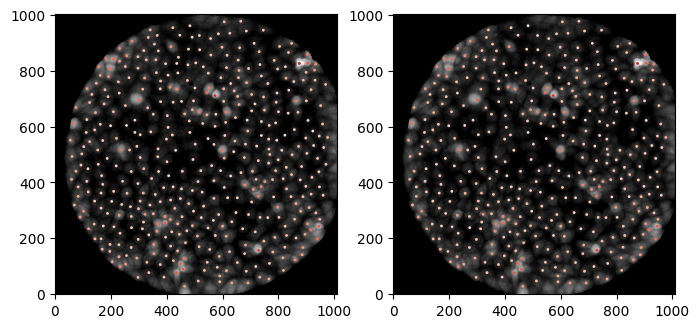

In [19]:
idx = 2

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].imshow(im[idx].T, origin="lower", cmap="gray", vmin=1.37);
ax[1].imshow(im[idx].T, origin="lower", cmap="gray", vmin=1.37);
ax[0].scatter(unfiltered_df[unfiltered_df.frame==idx].x, unfiltered_df[unfiltered_df.frame==idx].y, s=1, cmap="Reds", c=unfiltered_df[unfiltered_df.frame==idx].h_max, vmin=0, vmax=h_max)#, 'r.', ms=3);
ax[1].scatter(filtered_df[filtered_df.frame==idx].x, filtered_df[filtered_df.frame==idx].y, s=1, cmap="Reds", c=filtered_df[filtered_df.frame==idx].h_max, vmin=0, vmax=h_max)#, 'r.', ms=3);

print(f"Before: {len(unfiltered_df[unfiltered_df.frame==idx])}")
print(f"After:  {len(filtered_df[filtered_df.frame==idx])}")

420


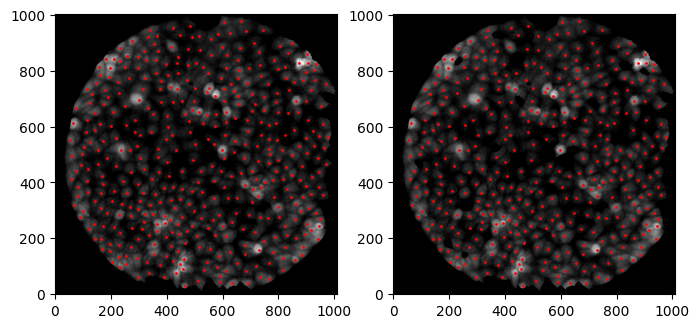

In [20]:
filtered_areas = np.copy(areas[idx])

for l in range(0, areas[idx].max()):
    if l not in filtered_df[filtered_df.frame==idx].label.values:
        filtered_areas[filtered_areas == l] = 0

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].imshow((im[idx]*(areas[idx]>0)).T, origin="lower", cmap="gray", vmin=1.37);
ax[1].imshow((im[idx]*(filtered_areas>0)).T, origin="lower", cmap="gray", vmin=1.37);

ax[0].plot(unfiltered_df[unfiltered_df.frame==idx].x, unfiltered_df[unfiltered_df.frame==idx].y, 'r.', ms=2);
ax[1].plot(filtered_df[filtered_df.frame==idx].x, filtered_df[filtered_df.frame==idx].y, 'r.', ms=2);

print(sum(unfiltered_df.frame==idx))

In [ ]:
'''
B2-5
A_min = 150
A_max = 3000
V_min = 1000
V_max = 20_000
h_min = 2
h_max = 18
'''

'''
A2-1, A2-7
A_min = 100  / pix_to_um[0] ** 2
A_max = 2000 / pix_to_um[0] ** 2
V_min = 1000 / pix_to_um[0] ** 2
V_max = 10_000 / pix_to_um[0] ** 2
h_min = 1
h_max = 18
'''

'''
B1-13, B1-22
A_min = 100  / pix_to_um[0] ** 2
A_max = 2000 / pix_to_um[0] ** 2
V_min = 1000 / pix_to_um[0] ** 2
V_max = 8_000 / pix_to_um[0] ** 2
h_min = 1
h_max = 17
'''


'''
B1-25
A_min = 100  / pix_to_um[0] ** 2
A_max = 2000 / pix_to_um[0] ** 2
V_min = 1000 / pix_to_um[0] ** 2
V_max = 8_000 / pix_to_um[0] ** 2
h_min = 1
h_max = 18
'''